# EEMeter Heating and Cooling Visualizations

Clayton Miller - miller.clayton@gmail.com

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import timeit
import os
from datetime import datetime
from __future__ import division
from pylab import *
import matplotlib.dates as mdates
from matplotlib import ticker
import datetime
import matplotlib

In [2]:
sns.set_style("whitegrid")

In [3]:
%matplotlib inline

In [4]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [5]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)

In [6]:
temp = pd.read_csv((os.path.join(repos_path,"data/interim/temp_open_utc_complete.csv")), index_col='timestamp', parse_dates=True).tz_localize('utc')

In [22]:
temp_modelheating = pd.read_csv(os.path.join(repos_path,"data/interim/temp_eemeter_predictedheating.csv"), index_col='timestamp', parse_dates=True)
temp_modelcooling = pd.read_csv(os.path.join(repos_path,"data/interim/temp_eemeter_predictedcooling.csv"), index_col='timestamp', parse_dates=True)


In [98]:
building = "Office_Phebian"
#building = "PrimClass_Jacob"

In [99]:
meta.T[building].timezone

'America/New_York'

In [100]:
def get_individual_data(temp, meta, building):
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    return pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))

def get_individual_data_notz(temp, meta, building):
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    return pd.DataFrame(temp[building].truncate(before=start,after=end))

In [101]:
def plot_line_example(df_1, df_2,  color, vartitle):
    sns.set(rc={"figure.figsize": (12,4)})
    sns.set_style('whitegrid')
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    df_1.columns = ["Actual kWh"]
    #df_predicted.columns = ["Predicted kWh"]
    ax1 = fig.add_subplot(gs[1:60,:])
    df_1.plot(ax = ax1, legend=False)
    ax1.xaxis.set_visible(False)
    ax1.set_title("Hourly kWh")
    
    ax2 = fig.add_subplot(gs[68:,:])
    df_2 = df_2.tz_localize(None)
    x = mdates.drange(df_2.index[0], df_2.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df_2.columns), len(df_2.columns)+1)
    data = np.array(df_2.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap)
    ax2.set_title(vartitle)
    
    #leftspacing, 
    cbaxes = fig.add_axes([0.18, 0.08, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax2, orientation='horizontal', cax=cbaxes)
    
    ax2.axis('tight')
    ax2.xaxis_date()
    ax2.yaxis.set_visible(False)
    myFmt = mdates.DateFormatter('%b')
    ax2.xaxis.set_major_formatter(myFmt)

In [102]:
df = get_individual_data(temp, meta, building)#
df_heating = get_individual_data_notz(temp_modelheating, meta, building)
df_cooling = get_individual_data_notz(temp_modelcooling, meta, building)

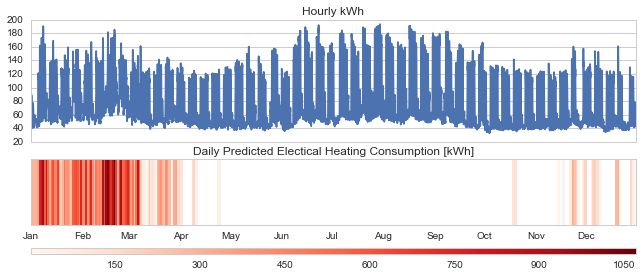

In [103]:
plot_line_example(df, df_heating, "Reds", "Daily Predicted Electical Heating Consumption [kWh]")
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/heating_example.png"));

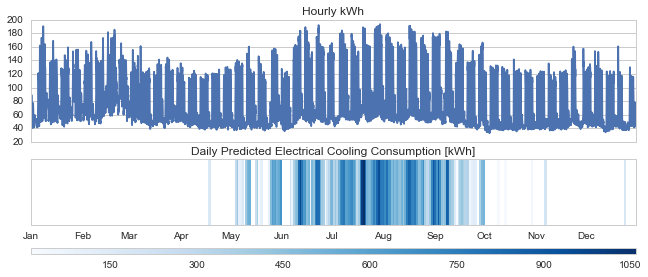

In [104]:
plot_line_example(df, df_cooling, "Blues", "Daily Predicted Electrical Cooling Consumption [kWh]")
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/cooling_example.png"));

# Overview heatmap

In [83]:
def heatmap_data(df):
    x = mdates.drange(df.index[0], df.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    return x,y

#This function changes the year for all of the buildings so that they can be overlapped for plotting
# THE RESULTING DATAFRAME IS ONLY FOR "GENERALIZED" PLOTTING TO GET THE DATA SETS TO OVERLAP -- DON'T PERFORM CALCULATIONS ON IT

def changeto2015(x):
    try:
        return x.replace(year=2015)
    except:
        return np.nan
    
def is_leap_and_29Feb(s):
    return (s.index.year % 4 == 0) & ((s.index.year % 100 != 0) | (s.index.year % 400 == 0)) & (s.index.month == 2) & (s.index.day == 29)

def generalize_timestamp_forplotting(meta, temp):
    temp_generalized = pd.DataFrame()
    buildinglist = list(meta.index)
    
    for building in buildinglist:
        #Change to timezone
        timezone = meta.T[building].timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data = pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))
        
        #Remove leap year day for 2012
        mask = is_leap_and_29Feb(building_data)
        building_data = building_data.loc[~mask]
        
        #Change to 2015 -- we arbitrarily use this year
        building_data.index = building_data.index.map(lambda t: changeto2015(t))
        
        #Remove tz awareness, resample to normalize the timestamps and ffill to get rid of the gaps
        building_data = building_data.tz_localize(None)
        building_data = building_data.resample('D').mean().sort_index()
        building_data = building_data.ffill()
        
        #Merge into dataset
        temp_generalized = pd.merge(temp_generalized, building_data, right_index=True, left_index=True, how='outer')
        temp_generalized = temp_generalized.resample('D').mean().sort_index()
        
        #print "finished building: "+building
    return temp_generalized

def generalize_timestamp_forplotting_notz(meta, temp):
    temp_generalized = pd.DataFrame()
    buildinglist = list(meta.index)
    
    for building in buildinglist:
        #Change to timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data = pd.DataFrame(temp[building].truncate(before=start,after=end))
        
        #Remove leap year day for 2012
        mask = is_leap_and_29Feb(building_data)
        building_data = building_data.loc[~mask]
        
        #Change to 2015 -- we arbitrarily use this year
        building_data.index = building_data.index.map(lambda t: changeto2015(t))
        
        #Remove tz awareness, resample to normalize the timestamps and ffill to get rid of the gaps
        building_data = building_data.tz_localize(None)
        building_data = building_data.resample('D').mean().sort_index()
#         building_data = building_data.ffill()
        
        #Merge into dataset
        temp_generalized = pd.merge(temp_generalized, building_data, right_index=True, left_index=True, how='outer')
        temp_generalized = temp_generalized.resample('D').mean().sort_index()
        
        #print "finished building: "+building
    return temp_generalized

def plotmap(df, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel):
    
    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (12,15)})
    sns.set_style("whitegrid")
    
    numberofplots = 1
    fig = plt.figure()
    
    x = mdates.drange(df.index[0], df.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    ax = fig.add_subplot(numberofplots, 1, 1)
    data = np.array(df.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    qmesh = ax.pcolormesh(x, y, datam, cmap=cmap)
    
    cbaxes = fig.add_axes([0.15, 0.15, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax=cbaxes)
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)
    
    ax.axis('tight')
    ax.xaxis_date()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    ax.set_xlabel(xaxislabel)
    ax.set_ylabel(yaxislabel)
    ax.set_title(graphiclabel)
    
    ax.set_yticklabels(df.columns)
    tick_locator = ticker.MaxNLocator(nbins=110)
    loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax.locator_params(axis='y', nbins=100)
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.subplots_adjust(bottom=0.2)

def plotmap_subplots(df, meta, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel, z_min, z_max):

    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (12,15)})
    sns.set_style("whitegrid")
    cmap = matplotlib.cm.get_cmap(color)
    
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    # Plot Offices
    df_office = df[df.columns[df.columns.str.contains("Office")]]
    office_height = int(len(df_office.T)/len(df.T)*100-2)
    ax1 = fig.add_subplot(gs[1:office_height,:])
    x,y = heatmap_data(df_office)
    data = np.array(df_office.T)
    datam = np.ma.array(data, mask=np.isnan(df_office))
    qmesh = ax1.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax1.axis('tight')
    ax1.xaxis_date()
    ax1.set_title("Offices")
    ax1.xaxis.set_visible(False)
    
    # Plot UnivLab
    df_lab = df[df.columns[df.columns.str.contains("UnivLab")]]
    lab_height = int(len(df_lab.T)/len(df.T)*100-2)
    ax2 = fig.add_subplot(gs[office_height+2:office_height+lab_height,:])
    x,y = heatmap_data(df_lab)
    data = np.array(df_lab.T)
    datam = np.ma.array(data, mask=np.isnan(df_lab))
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax2.axis('tight')
    ax2.xaxis_date()
    ax2.set_title("University Labs")
    ax2.xaxis.set_visible(False)
    
    # Plot UnivClass
    df_uniclass = df[df.columns[df.columns.str.contains("UnivClass")]]
    uniclass_height = int(len(df_uniclass.T)/len(df.T)*100-2)
    ax3 = fig.add_subplot(gs[office_height+lab_height+2:office_height+lab_height+uniclass_height,:])
    x,y = heatmap_data(df_uniclass)
    data = np.array(df_uniclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_uniclass))
    qmesh = ax3.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax3.axis('tight')
    ax3.xaxis_date()
    ax3.set_title("University Classrooms")
    ax3.xaxis.set_visible(False)

    # Plot PrimClass
    df_primclass = df[df.columns[df.columns.str.contains("PrimClass")]]
    primclass_height = int(len(df_primclass.T)/len(df.T)*100-2)
    ax4 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+2:office_height+lab_height+uniclass_height+primclass_height,:])
    x,y = heatmap_data(df_primclass)
    data = np.array(df_primclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_primclass))
    qmesh = ax4.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax4.axis('tight')
    ax4.xaxis_date()
    ax4.set_title("Primary/Secondary Classroom")
    ax4.xaxis.set_visible(False)

    
    # Plot Univ Dorms
    df_unidorm = df[df.columns[df.columns.str.contains("UnivDorm")]]
    unidorm_height = int(len(df_unidorm.T)/len(df.T)*100-2)
    ax5 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+primclass_height+2:office_height+lab_height+uniclass_height+primclass_height+unidorm_height,:])
    x,y = heatmap_data(df_unidorm)
    data = np.array(df_unidorm.T)
    datam = np.ma.array(data, mask=np.isnan(df_unidorm))
    qmesh = ax5.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax5.axis('tight')
    ax5.xaxis_date()
    ax5.set_title("University Dorms")
    
    cbaxes = fig.add_axes([0.18, 0.23, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, orientation='horizontal', cax=cbaxes) #ax=ax,
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)

    myFmt = mdates.DateFormatter('%b')
    ax5.xaxis.set_major_formatter(myFmt)
    
    fig.text(0.14, 0.5, yaxislabel, va='center', rotation='vertical')

In [84]:
#temp_modelheating_generalized

In [85]:
temp_modelheating_generalized = generalize_timestamp_forplotting_notz(meta, temp_modelheating)/meta.sqm
temp_modelcooling_generalized = generalize_timestamp_forplotting_notz(meta, temp_modelcooling)/meta.sqm

In [86]:
temp_modelheating_generalized_sorted_normalized = temp_modelheating_generalized[list(temp_modelheating_generalized.sum().sort_values().index)]
temp_modelcooling_generalized_sorted_normalized = temp_modelcooling_generalized[list(temp_modelcooling_generalized.sum().sort_values().index)]


In [87]:
temp_modelcooling_generalized_sorted_normalized.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2015-01-01 to 2015-12-31
Freq: D
Columns: 507 entries, UnivDorm_Antonio to UnivLab_Audra
dtypes: float64(507)
memory usage: 1.4 MB


In [88]:
temp_modelcooling_generalized_sorted_normalized.describe().T['max'].dropna().describe()

count    506.000000
mean       0.055130
std        0.127028
min        0.000000
25%        0.000000
50%        0.015171
75%        0.053275
max        1.297681
Name: max, dtype: float64

In [89]:
temp_modelheating_generalized_sorted_normalized.describe().T['max'].dropna().describe()

count    502.000000
mean       0.062257
std        0.099774
min        0.000000
25%        0.000000
50%        0.030927
75%        0.071330
max        0.774200
Name: max, dtype: float64

In [90]:
temp_modelcooling_generalized_sorted_normalized = temp_modelcooling_generalized_sorted_normalized.replace(np.nan, 0)
temp_modelheating_generalized_sorted_normalized = temp_modelheating_generalized_sorted_normalized.replace(np.nan, 0)

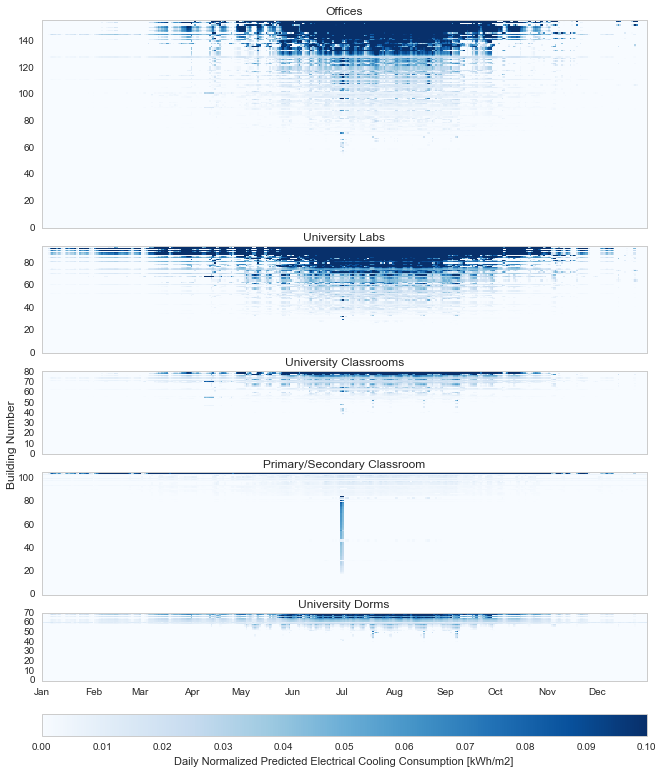

In [97]:
plotmap_subplots(temp_modelcooling_generalized_sorted_normalized, meta, 'Blues', "Daily Normalized Predicted Electrical Cooling Consumption [kWh/m2]",
                 " ", "Building Number", " ", "Daily Predicted Cooling Consumption", 0, 0.1)
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/cooling_heatmap.png"));

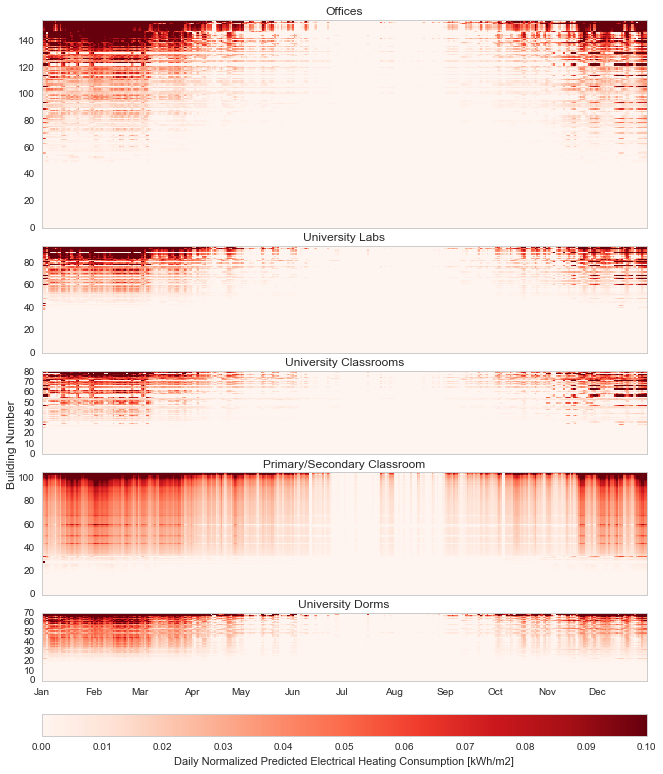

In [96]:
plotmap_subplots(temp_modelheating_generalized_sorted_normalized, meta, 'Reds', "Daily Normalized Predicted Electrical Heating Consumption [kWh/m2]",
                 " ", "Building Number", " ", "Daily Predicted Cooling Consumption", 0, 0.1)
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/heating_heatmap.png"));

In [121]:
#temp_spearman_generalized.describe(include="all")

In [122]:
#from pandas_summary import DataFrameSummary

In [123]:
#dfs = DataFrameSummary(temp_spearman_generalized)

In [120]:
#building

In [119]:
#dfs[building]["top_correlations"]